# Setup

In [1]:
from ultralytics import YOLO, RTDETR
import torch
import os
import numpy as np
import random

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn 
random.seed(seed) 
np.random.seed(seed) 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)   
cudnn.benchmark, cudnn.deterministic = False, True

In [2]:
device_id=0
batch_size=8

In [3]:
os.chdir("../../")

In [4]:
yolo_dataset_path = './data/xami_dataset_yolov8/'

In [5]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print('Clases:', classes)
    
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'
train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)
train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size

Clases: {0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


## Model setup

In [6]:
os.getcwd()

'/Users/iulia/Desktop/tempp/XAMI-model'

In [7]:
from xami_model.mobile_sam.mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
print("DEVICE:", device)
det_type = 'yolov8' # 'yolov8' or 'rtdetr'

detr_checkpoint = f'./xami_model/train/weights/{det_type}_sam_weights/{det_type}_detect_300e_best.pt'
sam_checkpoint = f'./xami_model/train/weights/{det_type}_sam_weights/{det_type}_sam.pth'

if det_type == 'yolov8':
    detector_pretrained_model = YOLO(detr_checkpoint); 

elif det_type == 'rtdetr':
    detector_pretrained_model = RTDETR(detr_checkpoint); 

else:
    print("Detection type must be 'yolov8' or 'rtdetr'")
    
detector_pretrained_model.to(device);
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

DEVICE: cpu


In [9]:
from xami_model.model_predictor import xami

xami_model = xami.XAMI(
    mobile_sam_model,
    device,
    predictor,
    use_yolo_masks=True, # this works only for YOLO as detection model
    wt_threshold=0.85,
    wt_classes_ids = [1.0, 4.0])

if det_type == 'rtdetr' and xami_model.use_yolo_masks==True:
    print('The Real-Time Detection Transformer does not support mask generation yet.\
    \nWe will set use_yolo_masks=False')
    xami_model.use_yolo_masks = False

for param in xami_model.model.parameters():
    param.requires_grad = False

# Performance evaluation

This section provides some methods to evaluate the performance of the model.

In [ ]:
xami_model.model.eval()

with torch.no_grad():

    # eval on training set
    t_results = xami_model.run_yolo_sam_epoch(
        detector_pretrained_model,
        phase='evaluation',
        batch_size=batch_size,
        image_files=train_image_files,
        images_dir=train_dir,
        num_batches=train_num_batches,
        optimizer=None)

    # eval on validation set
    v_results = xami_model.run_yolo_sam_epoch(
        detector_pretrained_model,
        phase='evaluation',
        batch_size=batch_size,
        image_files=valid_image_files,
        images_dir=valid_dir,
        num_batches=valid_num_batches,
        optimizer=None)

In [ ]:
v_results.keys()

dict_keys(['preds', 'gts', 'gt_cls', 'pred_cls', 'iou_scores', 'pred_images', 'all_preds', 'all_gts', 'all_gt_cls', 'all_pred_cls', 'all_iou_scores'])

In [ ]:
del t_results['pred_images']

## Mask IoU metrics

**annotations IoU**

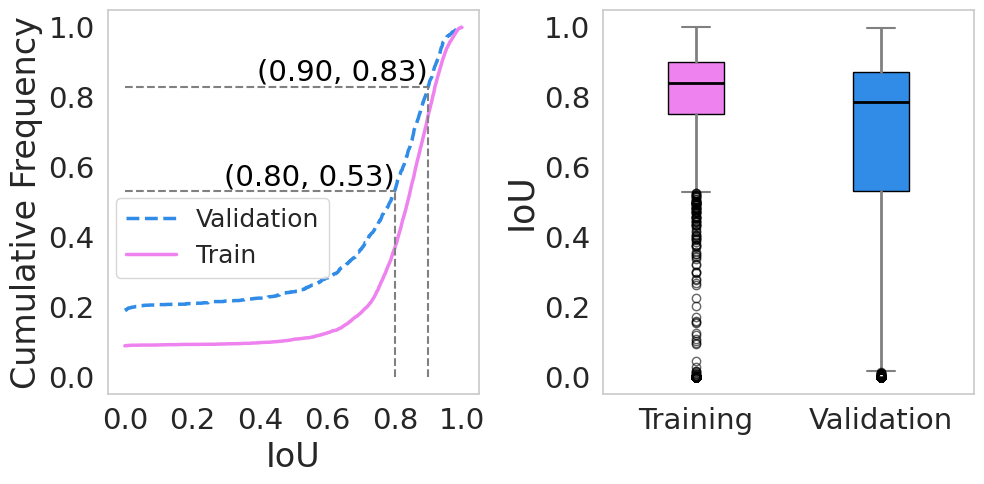

In [ ]:
from xami_model.losses import metrics_utils

v_ious = metrics_utils.ann_ious(v_results, 'Validation')
t_ious = metrics_utils.ann_ious(t_results, 'Train')

metrics_utils.plot_ious(t_ious, v_ious, box_anchor=(0.63, 0.27), save=True, save_path='./ious.pdf')

**IoUs per images**

In [ ]:
img_ious = []

for img_preds, img_gts in zip(v_results['all_gts'], v_results['all_preds']):
    _, _, _, img_iou = metrics_utils.compute_metrics_with_range(img_preds, img_gts)
    img_ious.append(img_iou)
print('Images (Validation)\nMean', np.mean(img_ious), 'Std:', np.std(img_ious), \
     '\nMedian:', np.median(img_ious))

## Metrics per class

In [ ]:
import pandas as pd

data=[]

overall_tp_ious, overall_fp_ious, overall_fn_ious, class_metrics, cls_det = metrics_utils.iou_cls_tp_fp_fn(
    v_results['all_preds'],
    v_results['all_gts'],
    v_results['all_pred_cls'],
    v_results['all_gt_cls'],
    iou_threshold=0.2) # minimum IoU to consider TPs

for cls, metrics in class_metrics.items():
    tp_count = len(metrics['tp_ious'])
    fp_count = len(metrics['fp_ious'])
    fn_count = len(metrics['fn_ious'])
    
    recall_det = np.round(tp_count / (tp_count + fn_count), 2) if (tp_count + fn_count) > 0 else 0.0
    precision_det = np.round(tp_count / (tp_count + fp_count), 2) if (tp_count + fp_count) > 0 else 0.0
    perc_fp = np.round(fp_count / (tp_count + fp_count + fn_count), 2) if (tp_count + fp_count + fn_count) > 0 else 0.0
    perc_fn = np.round(fn_count / (tp_count + fp_count + fn_count), 2) if (tp_count + fp_count + fn_count) > 0 else 0.0
    iou_tp = np.round(np.mean(metrics['tp_ious']), 2)
    data.append([cls, precision_det, recall_det, perc_fp, perc_fn, iou_tp])

df = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'FP', 'FN', 'IoU_TP'])
df

,Class,Prec,Recall,FP,FN,IoU_TP
0,0.0,0.89,0.94,0.10,0.05,0.88
1,1.0,1.00,0.33,0.00,0.67,0.57
2,2.0,0.71,0.73,0.23,0.21,0.76
3,3.0,0.81,0.86,0.17,0.12,0.82
4,4.0,0.80,0.74,0.15,0.22,0.80


In [ ]:
np.round(np.mean(df['Prec']), 2), np.round(np.mean(df['Recall']), 2), np.round(np.mean(df['FP']), 2), \
np.round(np.mean(df['FN']), 2), np.round(np.mean(df['IoU_TP']), 2)

(0.84, 0.72, 0.13, 0.25, 0.77)

In [ ]:
import tqdm
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from collections import defaultdict

metric_thresholds = [[0.5], [0.75], [0.5, 0.9]]
all_mAP_metrics = defaultdict(dict)

for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    metric = MeanAveragePrecision(
        iou_type="segm",
        iou_thresholds=threshold,
        max_detection_thresholds=None,
        class_metrics=True,
        extended_summary=False
    )

    t_metrics = metrics_utils.mAP_metrics(
        metric,
        t_results['all_preds'],
        t_results['all_gts'],
        t_results['all_gt_cls'],
        t_results['all_pred_cls'],
        t_results['all_iou_scores'],
        show_metrics=False
    )
    v_metrics = metrics_utils.mAP_metrics(
        metric,
        v_results['all_preds'],
        v_results['all_gts'],
        v_results['all_gt_cls'],
        v_results['all_pred_cls'],
        v_results['all_iou_scores'],
        show_metrics=False
    )

## IoU plots 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

num_samples = 16
random_indices = random.sample(range(len(v_results['pred_images'])), num_samples)
images = [v_results['pred_images'][i] for i in random_indices]
selected_preds = [v_results['all_preds'][i] for i in random_indices]

fig, axes = plt.subplots(4, 4, figsize=(36, 36))

for j, (image_name, pred_mask) in enumerate(zip(images, selected_preds)):
    row, col = divmod(j, 4)
    gt_masks = v_results['all_gts'][random_indices[j]]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name[:13]} ({j+1})', fontsize=34, pad=10)

    tp_color = np.array([0, 255, 0, 102]) / 255  
    fp_color = np.array([255, 0, 0, 102]) / 255  
    fn_color = np.array([0, 0, 255, 102]) / 255  

    true_positive_mask, false_positive_mask, false_negative_mask, iou = metrics_utils.compute_metrics_with_range(gt_masks, pred_mask, image)
    h, w = true_positive_mask.shape[-2:]
    true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
    false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
    false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

    ax_simple.imshow(false_positive_mask)
    ax_simple.imshow(false_negative_mask)
    ax_simple.imshow(true_positive_mask)

    ax_simple.text(300, 480, f'IoU ~ {iou:.2f}', fontsize=33, color='black')

tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.5)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.5)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.5)

fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.0003), ncol=3, fontsize=33)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.08, wspace=0.05)
# plt.savefig('tp_fp_fn_ious.pdf', dpi=600)
plt.show()

In [14]:
# original images

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(36, 36))

for j, (image_name, pred_mask) in enumerate(zip(images, selected_preds)):
    row, col = divmod(j, 4)
    gt_masks = v_results['all_gts'][random_indices[j]]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name[:13]} ({j+1})', fontsize=34, pad=10)

plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.08, wspace=0.05)
plt.show()